In [1]:
import xarray
import os
import numpy as np
from GridcellDataset import GridcellDataset
from pathos.multiprocessing import Pool
from random import sample
from datetime import datetime
import iris
import scipy as sp
import sklearn

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def _reduce_dim(cube, dim, scale_factor):
    new_dim = np.linspace(cube.coord(dim).points[0], 
                          cube.coord(dim).points[-1],
                          num = cube.coord(dim).points.shape[0] // scale_factor)
    return new_dim

def upscale(cube, scale_factor):
    new = cube.copy()
    new_lat = _reduce_dim(cube, 'grid_latitude', scale_factor)
    new_lon = _reduce_dim(cube, 'grid_longitude', scale_factor)
    return new.interpolate(sample_points=[('grid_latitude', new_lat), ('grid_longitude', new_lon)],
                           scheme=iris.analysis.Linear())

def bilinear_downscale(upscaled, target):
    return upscaled.regrid(target, iris.analysis.Linear()) # defaults to n-linear

In [3]:
def bilinear_downscale_xr(darray, scale_factor):
    time = iris.coords.DimCoord(darray.forecast_reference_time.astype(int),
                                standard_name='time')
    latitude = iris.coords.DimCoord(darray.grid_latitude,
                                    standard_name='grid_latitude')
    longitude = iris.coords.DimCoord(darray.grid_longitude,
                                     standard_name='grid_longitude')

    cube = iris.cube.Cube(darray,
                          dim_coords_and_dims=[(time, 0), (latitude, 1), (longitude, 2)])
    new = darray.copy()
    new.data = bilinear_downscale(upscale(cube, scale_factor), cube).data
    
    return new

In [4]:
def get_set(paths, scale_factor, n):
    sets = [xarray.open_dataset(tp)['stratiform_rainfall_amount'].isel(dim0=2) for tp in paths]
    hr = xarray.concat([ts.drop('forecast_period_3') for ts in sets if 'forecast_period_3' in ts.coords],
              dim='forecast_reference_time')
    hr = hr.reindex(forecast_reference_time=sorted(hr.forecast_reference_time.data))
    lr = bilinear_downscale_xr(hr, scale_factor)
    
    template = lr[:, n:-n, n:-n]
    d = xarray.Dataset({'stratiform_rainfall_amount': lr[:, n:-n, n:-n]})
    d['stratiform_rainfall_amount_left'] = (template.dims, lr[:, :-2*n, n:-n].data)
    d['stratiform_rainfall_amount_right'] = (template.dims, lr[:, 2*n:, n:-n].data)
    d['stratiform_rainfall_amount_up'] = (template.dims, lr[:, n:-n, :-2*n].data)
    d['stratiform_rainfall_amount_down'] = (template.dims, lr[:, n:-n, 2*n:].data)
    d['target'] = hr[:, n:-n, n:-n]
    
    return d

In [5]:
def get_set(paths, scale_factor, ns):
    sets = [xarray.open_dataset(tp)['stratiform_rainfall_amount'].isel(dim0=2) for tp in paths]
    hr = xarray.concat([ts.drop('forecast_period_3') for ts in sets if 'forecast_period_3' in ts.coords],
              dim='forecast_reference_time')
    hr = hr.reindex(forecast_reference_time=sorted(hr.forecast_reference_time.data))
    lr = bilinear_downscale_xr(hr, scale_factor)
    
    m = max(ns)
    template = lr[:, m:-m, m:-m]
    d = xarray.Dataset({'stratiform_rainfall_amount': lr[:, m:-m, m:-m]})
    d['target'] = hr[:, m:-m, m:-m]
    
    return d

In [6]:
path = '../netcdf/'
paths = [f for f in os.listdir(path) if f[:5] == 'prods']
train_paths = [p for p in paths if int(p[26:28]) < 10]
test_paths = [p for p in paths if int(p[26:28]) > 10]

In [7]:
train = get_set([path + tp for tp in train_paths], 8, [3])
test = get_set([path + tp for tp in test_paths], 8, [3])

In [8]:
hr = train['target'][4,:40,:400].data

In [164]:
hr2 = train['target'][5,:40,:400].data

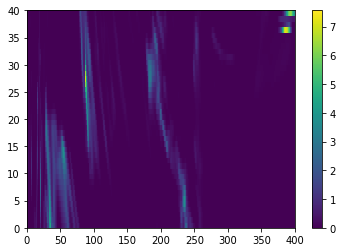

In [165]:
plt.pcolormesh(hr2); plt.colorbar(); plt.show()

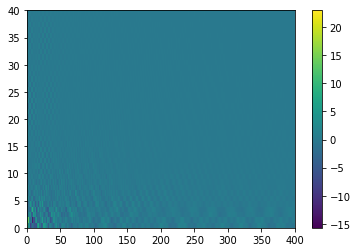

In [167]:
hrft2 = sp.fftpack.dct(sp.fftpack.dct(hr2, norm='ortho', axis=0), norm='ortho', axis=1)
u = sp.fftpack.idct(sp.fftpack.idct(hrft2[:16, :160], norm='ortho', axis=1), norm='ortho', axis=0)
plt.pcolormesh(hrft2); plt.colorbar(); plt.show()

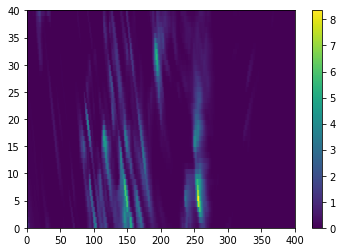

In [38]:
plt.pcolormesh(hr); plt.colorbar(); plt.show()

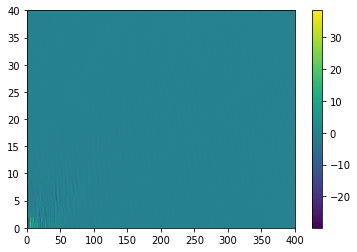

In [124]:
hrft = sp.fftpack.dct(sp.fftpack.dct(hr, norm='ortho', axis=0), norm='ortho', axis=1)
u = sp.fftpack.idct(sp.fftpack.idct(hrft[:16, :160], norm='ortho', axis=1), norm='ortho', axis=0)
plt.pcolormesh(hrft); plt.colorbar(); plt.show()

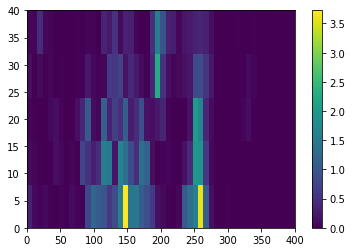

In [91]:
plt.pcolormesh(up_res(lr)); plt.colorbar(); plt.show()

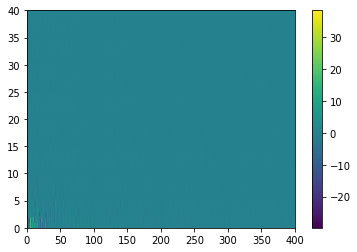

In [128]:
lrft = sp.fftpack.dct(sp.fftpack.dct(up_res(lr), norm='ortho', axis=0), norm='ortho', axis=1)
u = sp.fftpack.idct(sp.fftpack.idct(lrft, norm='ortho', axis=1), norm='ortho', axis=0)
plt.pcolormesh(lrft); plt.colorbar(); plt.show()

In [141]:
tween = np.outer(np.linspace(0, 1, 40), np.linspace(0, 1, 400))

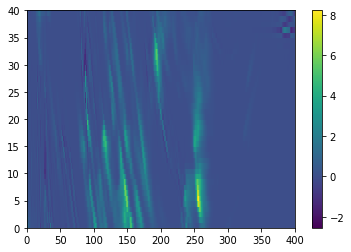

In [174]:
mix = ((1 - tween) * hrft) + (tween) * hrft2 * 10
u = sp.fftpack.idct(sp.fftpack.idct(mix, norm='ortho', axis=1), norm='ortho', axis=0)
plt.pcolormesh(u); plt.colorbar(); plt.show()

In [83]:
def reduce_res(x):
    return x.reshape((x.shape[0]//n,n,-1,n)).mean(axis=3).mean(1)

n = 8
lr = reduce_res(hr)

In [68]:
x_0 = np.random.rand(*hr.shape)
x_i = x_0

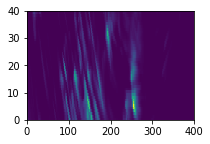

In [69]:
plt.figure(figsize=(3,2))
plt.pcolormesh(hr);

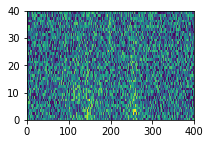

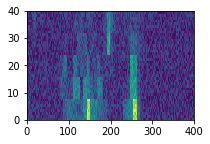

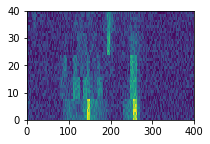

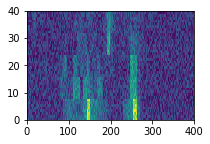

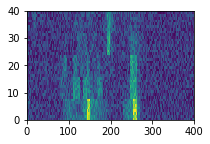

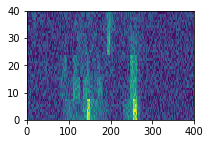

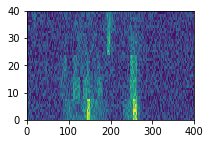

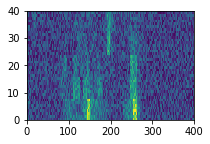

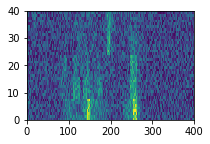

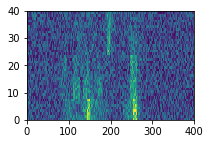

In [90]:
def up_res(x):
    return x.repeat(repeats=8, axis=1).repeat(repeats=8, axis=0)

def constraint(d):
    if d < 1:
        return 1-d
    if 1 <= d <= 2:
        return 0
    else:
        return d-2

x_0 = np.random.rand(*hr.shape)
x_i = x_0

a = 0.1
for i in range(10000):
    r_i = up_res(lr - reduce_res(x_i))
    r2_i = constraint(np.mean(np.square(up_res(lr) - x_i))) * up_res(lr) - x_i
    x_i += a * (r_i - 0.001 * r2_i)
    if i%1000 == 0:
        plt.figure(figsize=(3,2))
        plt.pcolormesh(x_i)
        plt.show()

In [87]:
np.mean(np.square(up_res(lr) - x_i))

2499.9999989775179

In [79]:
r_i.repeat(repeats=8, axis=1).repeat(repeats=8, axis=0).shape

(40, 400)